In [2]:
# === 0. Imports en config ===
import os, re
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

PATH_VESSEL = r"C:\Users\Wesse\OneDrive\Documents\WESSEL SCHOOL\Master\TIL Python Programming\TIL6022-group-project\OneDrive_1_27-10-2025\Vesselposition_data_20-24Aug2025.csv"
PATH_WEATHER = r"SAIL_Amsterdam_10min_Weather_2025-08-20_to_2025-08-24.csv"
PATH_SENSORS_LOC = r"sensor-location.xlsx - Sheet1.csv"
PATH_SENSORS = r"sensordata_SAIL2025.csv"

#Load pre-processed datasets

vessels = pd.read_csv(PATH_VESSEL).rename(columns={"upload-timestamp": "timestamp"}).drop(columns=["stale_since"])
weather = pd.read_csv(PATH_WEATHER)
sensors_location = pd.read_csv(PATH_SENSORS_LOC).rename(columns={"Objectnummer": "sensor_id"})
sensors = pd.read_csv(PATH_SENSORS, parse_dates=["timestamp"])


# xgb_params = dict(
#     objective="reg:squarederror", tree_method="hist",
#     max_depth=6, learning_rate=0.05,
#     subsample=0.8, colsample_bytree=0.8,
#     reg_lambda=1.0, reg_alpha=1e-4,
#     n_estimators=10_000, n_jobs=-1, random_state=42,
#     eval_metric="rmse", early_stopping_rounds=100
# )
# VERBOSE_EVERY = 50



C:\Users\Wesse\AppData\Local\Temp\ipykernel_30788\4199311266.py:18: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  vessels = pd.read_csv(PATH_VESSEL).rename(columns={"upload-timestamp": "timestamp"}).drop(columns=["stale_since"])


In [3]:
#Mutations sensor information

#Replace , by r . so it can be used in calculations
sensors_location["Effectieve breedte"] = (
    sensors_location["Effectieve breedte"]
    .astype(str)
    .str.replace(",", ".")
    .astype(float)
)

# Retrieve latitude and longitude information in separate columns
sensors_location[["lat", "lon"]] = (
    sensors_location["Lat/Long"]
    .str.replace(" ", "")  
    .str.split(",", expand=True)
    .astype(float)
)

sensor_prefixes = ("CMSA-", "GACM-", "GASA-", "GVCV-")

#Divide all counts by the effective width of the sensor location
width = sensors_location.set_index("sensor_id")["Effectieve breedte"].to_dict()

for col in sensors.columns:
    if "_" in col:  
        sensor_id = col.split("_")[0]
        if sensor_id in width:
            sensors[col] = sensors[col] / (width[sensor_id])



In [4]:
## Mutations weather data

# replace 24 by 00 to account for UTC datetime
weather["DateTime"] = weather["DateTime"].str.replace(" 24:", " 00:", regex=False)

# Convert to UTC datetime and round up for every 3 minutes
weather["DateTime"] = pd.to_datetime(weather["DateTime"], format="%Y%m%d %H:%M")
weather = weather.set_index("DateTime")
weather_3min = weather.resample("3min").nearest()
weather_3min = weather_3min.reset_index()

In [5]:
## Mutations vessel data

# Convert to UTC datetime and round up for every 3 minutes
vessels["timestamp"] = pd.to_datetime(vessels["timestamp"], utc=True, errors="coerce")
vessels["timestamp"] = vessels["timestamp"].dt.floor("3min")

#Take average longitude and latitude over 3 minutes and srot by datetime
vessels = (
    vessels.groupby(["timestamp", "imo-number"], as_index=False)
    .agg({
        "lat": "mean",
        "lon": "mean",
        "length": "first"
    }).dropna(subset=["timestamp", "imo-number", "lat", "lon", "length"])
)


In [6]:
##Combining vessel, weather and sensor data

#Ensure compatitibility datetime dataset
vessels["timestamp"] = pd.to_datetime(vessels["timestamp"], utc=True)
sensors["timestamp"] = pd.to_datetime(sensors["timestamp"], utc=True)
weather_3min["DateTime"] = pd.to_datetime(weather_3min["DateTime"], utc=True) 

#Merge datasets
combined = sensors.merge(vessels, on="timestamp", how="inner")
combined = combined.merge(
    weather_3min.rename(columns={"DateTime": "timestamp"})[
        ["timestamp", "Temperature_°C", "Humidity_%", "Rain_mm"]
    ],
    on="timestamp",
    how="left"   # keep all rows from sensors+vessels even if weather missing
)
combined = combined[combined["length"] > 10000]

In [7]:
#Calculate distance sensors to vessels every three minutes

# Merge sensor coordinates into the combined dataframe
lat_lookup = sensors_location.set_index("sensor_id")["lat"].to_dict()
lon_lookup = sensors_location.set_index("sensor_id")["lon"].to_dict()

#Haversine function for accurate distance calculation
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius (meters)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))


# Compute distance for every vessel at every timestamp to every sensor 
for _, sensor in sensors_location.iterrows():
    sensor_id = sensor["sensor_id"]
    s_lat = sensor["lat"]
    s_lon = sensor["lon"]
    
    dist_col = f"dist_{sensor_id}" 
    combined[dist_col] = haversine(s_lat, s_lon, combined["lat"], combined["lon"])

print(combined.isna().sum().tolist())
print(combined.columns.tolist())
print(combined.head())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['timestamp', 'CMSA-GAKH-01_0', 'CMSA-GAKH-01_180', 'CMSA-GAWW-11_120', 'CMSA-GAWW-11_300', 'CMSA-GAWW-12_115', 'CMSA-GAWW-12_295', 'CMSA-GAWW-13_120', 'CMSA-GAWW-13_300', 'CMSA-GAWW-14_40', 'CMSA-GAWW-14_220', 'CMSA-GAWW-15_30', 'CMSA-GAWW-15_210', 'CMSA-GAWW-16_30', 'CMSA-GAWW-16_210', 'CMSA-GAWW-17_40', 'CMSA-GAWW-17_220', 'CMSA-GAWW-19_115', 'CMSA-GAWW-19_295', 'CMSA-GAWW-20_120', 'CMSA-GAWW-20_300', 'CMSA-GAWW-21_120', 'CMSA-GAWW-21_300', 'CMSA-GAWW-23_109', 'CMSA-GAWW-23_289', 'GACM-04_50', 'GACM-04_230', 'GASA-01-A1_135', 'GASA-01-A1_315', 'GASA-01-A2_135', 'GASA-01-A2_315', 'GASA-01-B_135', 'GASA-01-B_315', 'GAS

In [8]:
# --- Cap all distances at 1000 m (no influence beyond that) ---
for col in [c for c in combined.columns if c.startswith("dist_")]:
    combined[col] = combined[col].clip(0, 1000)

# --- Weighted aggregation per timestamp ---
agg_rows = []
for ts, group in combined.groupby("timestamp"):
    # Compute inverse-distance weights per vessel
    dist_cols = [c for c in group.columns if c.startswith("dist_")]
    weights = 1 / (group[dist_cols].clip(lower=1))  # avoid division by zero

    temp = {
        "timestamp": ts,
        # Copy weather data directly (same for all vessels at timestamp)
        "Temperature_°C": group["Temperature_°C"].iloc[0],
        "Humidity_%": group["Humidity_%"].iloc[0],
        "Rain_mm": group["Rain_mm"].iloc[0],
    }

    # Weighted vessel length (heavier = more influence)
    temp["length_weighted"] = np.average(group["length"], weights=weights.mean(axis=1))

    # Weighted mean distances (closer vessels have more influence)
    for col in dist_cols:
        temp[f"{col}_weighted"] = np.average(group[col], weights=1 / (group[col] + 1))

    # Sensor targets (same for all vessels per timestamp)
    for target in [c for c in combined.columns if c.startswith(sensor_prefixes)]:
        temp[target] = group[target].iloc[0]

    agg_rows.append(temp)



agg_df = pd.DataFrame(agg_rows)

# === A. Extra features (tijd + interacties) ===
agg_df["hour"] = agg_df["timestamp"].dt.hour.astype("int16")
agg_df["dow"]  = agg_df["timestamp"].dt.dayofweek.astype("int8")
agg_df["is_we"] = (agg_df["dow"] >= 5).astype("int8")

# interacties
agg_df["temp_hum"] = agg_df["Temperature_°C"] * agg_df["Humidity_%"]
agg_df["rain_len"] = agg_df["Rain_mm"] * agg_df["length_weighted"]

# --- Clean data ---
agg_df = agg_df.dropna()

# Define the split timestamp (the moment where train ends and test begins)
split_time = pd.Timestamp("2025-08-24 00:00:00+02:00")

# Split the dataset
train_data = agg_df[agg_df["timestamp"] < split_time]
test_data  = agg_df[agg_df["timestamp"] >= split_time]

# --- Define predictors and targets ---
feature_cols = (
    ["Temperature_°C", "Humidity_%", "Rain_mm", "length_weighted"]
    + [c for c in agg_df.columns if c.startswith("dist_")]
)
target_cols = [c for c in agg_df.columns if c.startswith(sensor_prefixes)]




In [9]:
extra_feats = ["hour","dow","is_we","temp_hum","rain_len"]
feature_cols = feature_cols + extra_feats

In [10]:
VERBOSE_EVERY = 50

# --- Prepare matrices ---
X_train = train_data[feature_cols].values
X_test  = test_data[feature_cols].values
y_train = train_data[target_cols].values
y_test  = test_data[target_cols].values

# 1) vaste train/valid-split op trainingsdata
X_tr, X_va, y_tr_all, y_va_all = train_test_split(
    train_data[feature_cols].values.astype("float32"),
    train_data[target_cols].values.astype("float32"),
    test_size=0.2, random_state=42
)

# 2) basisparams (XGBoost 2.x: eval_metric en early_stopping_rounds in constructor)
xgb_params = dict(
    objective="reg:squarederror",
    tree_method="hist",
    max_depth=8,
    min_child_weight=1,
    gamma=0.0,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=2.0,
    reg_alpha=1e-3,
    n_estimators=20_000,      # hoog plafond
    early_stopping_rounds=200,
    eval_metric="rmse",
    n_jobs=-1,
    random_state=42
)

models, logs = {}, {}

for i, t in enumerate(target_cols):
    # log1p targets (aantallen zijn ≥0)
    y_tr = np.log1p(y_tr_all[:, i])
    y_va = np.log1p(y_va_all[:, i])

    m = XGBRegressor(**xgb_params)
    m.fit(
        X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_va, y_va)],
        verbose=VERBOSE_EVERY
    )
    models[t] = m
    logs[t] = m.evals_result()

[0]	validation_0-rmse:1.21983	validation_1-rmse:1.18880
[50]	validation_0-rmse:0.35899	validation_1-rmse:0.40091
[100]	validation_0-rmse:0.18716	validation_1-rmse:0.31464
[150]	validation_0-rmse:0.14272	validation_1-rmse:0.31298
[200]	validation_0-rmse:0.11996	validation_1-rmse:0.31552
[250]	validation_0-rmse:0.10699	validation_1-rmse:0.31731
[300]	validation_0-rmse:0.09517	validation_1-rmse:0.31853
[326]	validation_0-rmse:0.08983	validation_1-rmse:0.31936
[0]	validation_0-rmse:1.17307	validation_1-rmse:1.14944
[50]	validation_0-rmse:0.34094	validation_1-rmse:0.39025
[100]	validation_0-rmse:0.17675	validation_1-rmse:0.31540
[150]	validation_0-rmse:0.13315	validation_1-rmse:0.31648
[200]	validation_0-rmse:0.11252	validation_1-rmse:0.31839
[250]	validation_0-rmse:0.09918	validation_1-rmse:0.32067
[300]	validation_0-rmse:0.08858	validation_1-rmse:0.32206
[308]	validation_0-rmse:0.08668	validation_1-rmse:0.32221
[0]	validation_0-rmse:1.06214	validation_1-rmse:1.03760
[50]	validation_0-rmse

In [11]:
# # === Voorspellen op testset + export met timestamp ===
# preds = np.column_stack([models[t].predict(X_test) for t in target_cols]).astype("float32")

# # timestamps uit je test_data in dezelfde volgorde
# ts_test = pd.to_datetime(test_data["timestamp"]).reset_index(drop=True)

# pred_df = pd.DataFrame(preds, columns=target_cols)
# pred_df.insert(0, "timestamp", ts_test)

# pred_df.to_csv("predicted_sensor_values_3min_xgb.csv", index=False)
# print("geschreven: predicted_sensor_values_3min_xgb.csv")


Test RMSE=4.3783  MAE=1.7864
geschreven: predicted_sensor_values_3min_xgb.csv


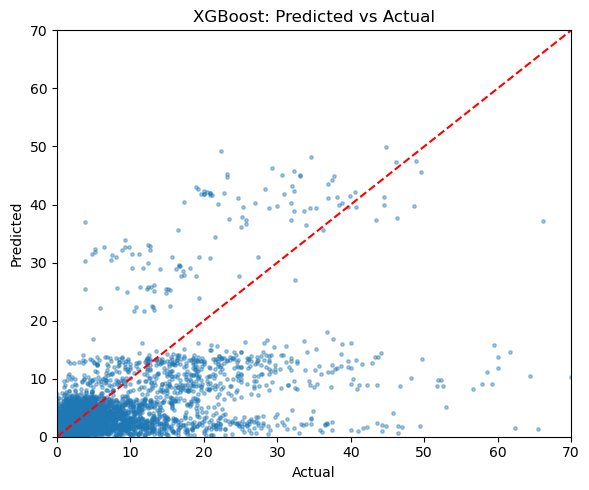

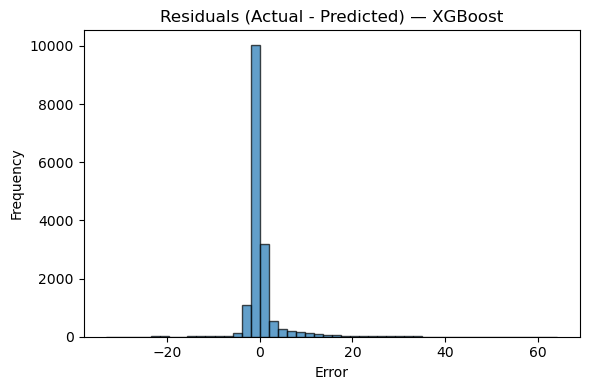

In [12]:
# === C. Voorspellen, inverse-transform, export + figuren ===
# testfeatures
X_test_mat = test_data[feature_cols].values.astype("float32")

# predict log-space en inverse
preds_log = np.column_stack([models[t].predict(X_test_mat) for t in target_cols])
preds = np.expm1(preds_log).astype("float32")
preds = np.clip(preds, 0, None)

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = float(np.sqrt(mean_squared_error(y_test, preds)))
mae  = float(mean_absolute_error(y_test, preds))
print(f"Test RMSE={rmse:.4f}  MAE={mae:.4f}")

# export met timestamp
ts_test = pd.to_datetime(test_data["timestamp"]).reset_index(drop=True)
pred_df = pd.DataFrame(preds, columns=target_cols)
pred_df.insert(0, "timestamp", ts_test)
pred_df.to_csv("predicted_sensor_values_3min_xgb.csv", index=False)
print("geschreven: predicted_sensor_values_3min_xgb.csv")

# figuren
yt = y_test.ravel()
yp = preds.ravel()

import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.scatter(yt, yp, s=6, alpha=0.4)
lims = [min(yt.min(), yp.min()), max(yt.max(), yp.max())]
plt.plot(lims, lims, linestyle="--", color="red")
plt.xlim(lims); plt.ylim(lims)
plt.title("XGBoost: Predicted vs Actual")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.tight_layout(); plt.show()

res = yt - yp
plt.figure(figsize=(6,4))
plt.hist(res, bins=50, alpha=0.7, edgecolor="k")
plt.title("Residuals (Actual - Predicted) — XGBoost")
plt.xlabel("Error"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()


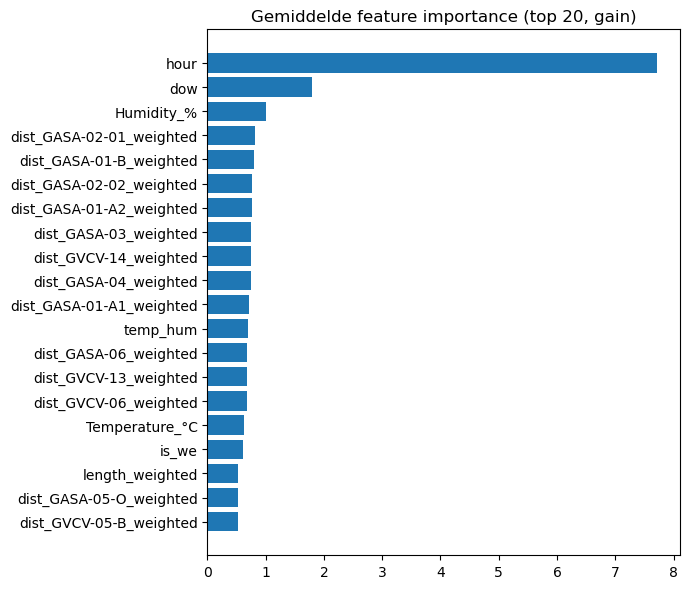

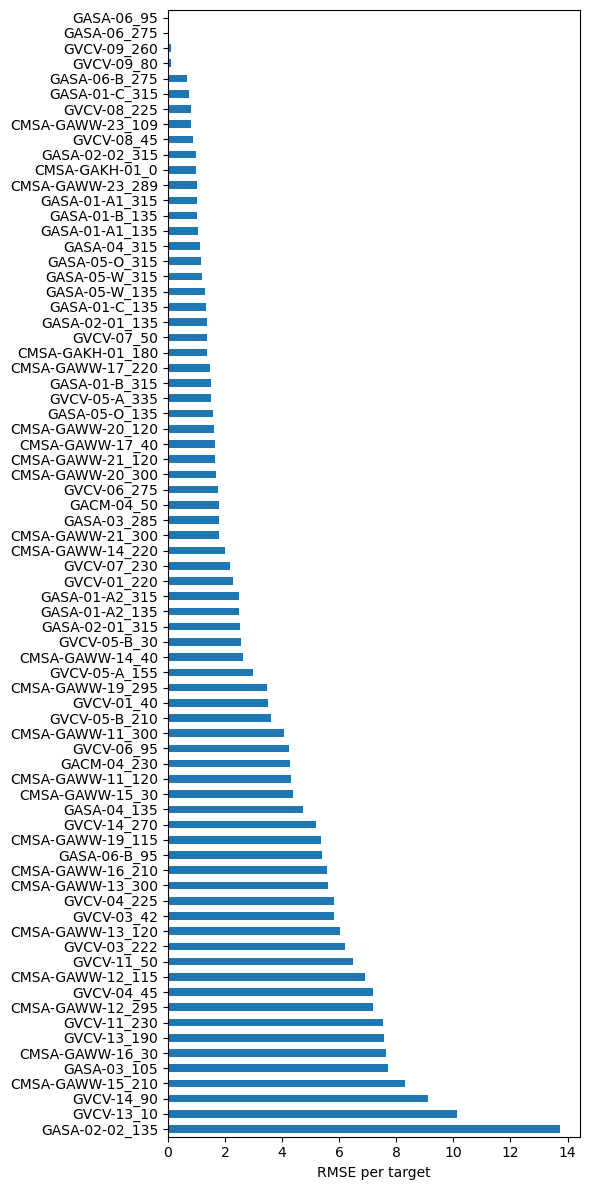

Gemiddelde RMSE over targets: 3.371
Hoogste RMSE: 13.747 (GASA-02-02_135)
Laagste RMSE: 0.000 (GASA-06_275)


In [13]:
# === D. Extra analyse: Feature importance en per-target fouten ===
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# 1) Gemiddelde feature importance over alle modellen
imps = []
for t, m in models.items():
    booster = m.get_booster()
    fmap = booster.get_score(importance_type="gain")
    vec = np.zeros(len(feature_cols))
    for k, v in fmap.items():
        idx = int(k[1:]) if k[1:].isdigit() else None
        if idx is not None and idx < len(vec):
            vec[idx] = v
    imps.append(vec)
imp_mean = np.mean(np.vstack(imps), axis=0)

order = np.argsort(imp_mean)[::-1][:20]
plt.figure(figsize=(7,6))
plt.barh(np.array(feature_cols)[order][::-1], imp_mean[order][::-1])
plt.title("Gemiddelde feature importance (top 20, gain)")
plt.tight_layout(); plt.show()

# 2) RMSE per target
rmse_targets = {
    t: np.sqrt(mean_squared_error(y_test[:,i], preds[:,i]))
    for i,t in enumerate(target_cols)
}
rmse_series = pd.Series(rmse_targets).sort_values(ascending=False)
plt.figure(figsize=(6,12))
rmse_series.plot(kind="barh")
plt.xlabel("RMSE per target"); plt.tight_layout(); plt.show()

# 3) Samenvatting van prestaties
print(f"Gemiddelde RMSE over targets: {rmse_series.mean():.3f}")
print(f"Hoogste RMSE: {rmse_series.max():.3f} ({rmse_series.idxmax()})")
print(f"Laagste RMSE: {rmse_series.min():.3f} ({rmse_series.idxmin()})")



Sample predictions (eerste 5 rijen, eerste 5 targets):
   CMSA-GAKH-01_0  CMSA-GAKH-01_180  CMSA-GAWW-11_120  CMSA-GAWW-11_300  \
0        0.831214          0.761233          8.371268         11.886982   
1        0.799529          0.777997          8.371970         12.733976   
2        0.948717          0.846794          8.659264         13.624961   
3        1.053841          0.888349          9.038301         13.569614   
4        0.737648          0.819448          8.641855         14.171715   

   CMSA-GAWW-12_115  
0         12.362379  
1          9.533319  
2         10.778734  
3         14.085236  
4         11.994173  
Actuals (zelfde rijen, targets):
   CMSA-GAKH-01_0  CMSA-GAKH-01_180  CMSA-GAWW-11_120  CMSA-GAWW-11_300  \
0        0.447761          2.537313         32.352941         20.882353   
1        2.089552          2.985075         17.941176         42.941176   
2        0.447761          2.686567         18.529412         23.823529   
3        0.298507          0.

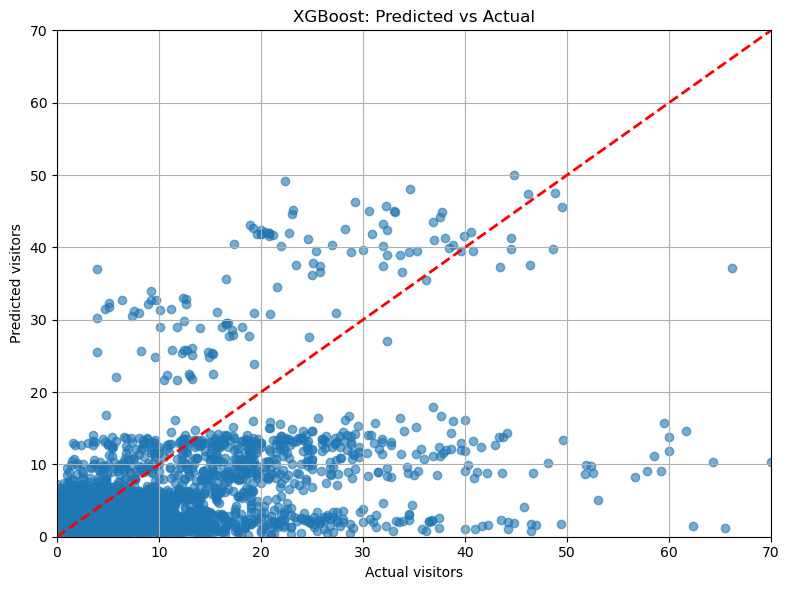

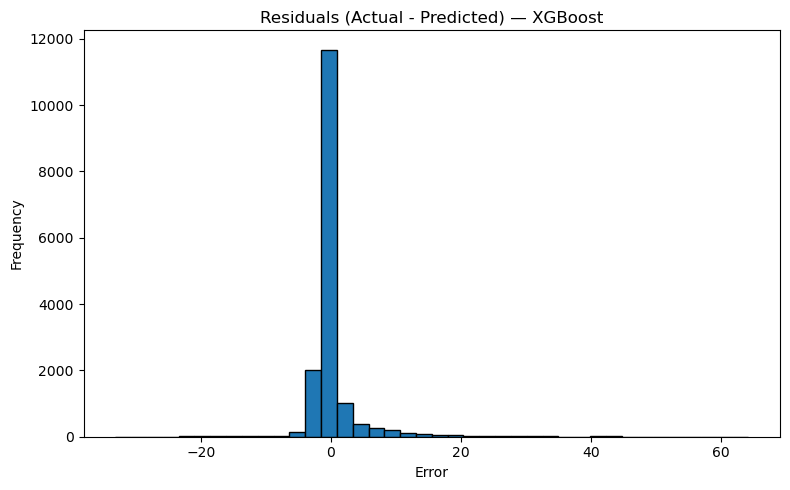

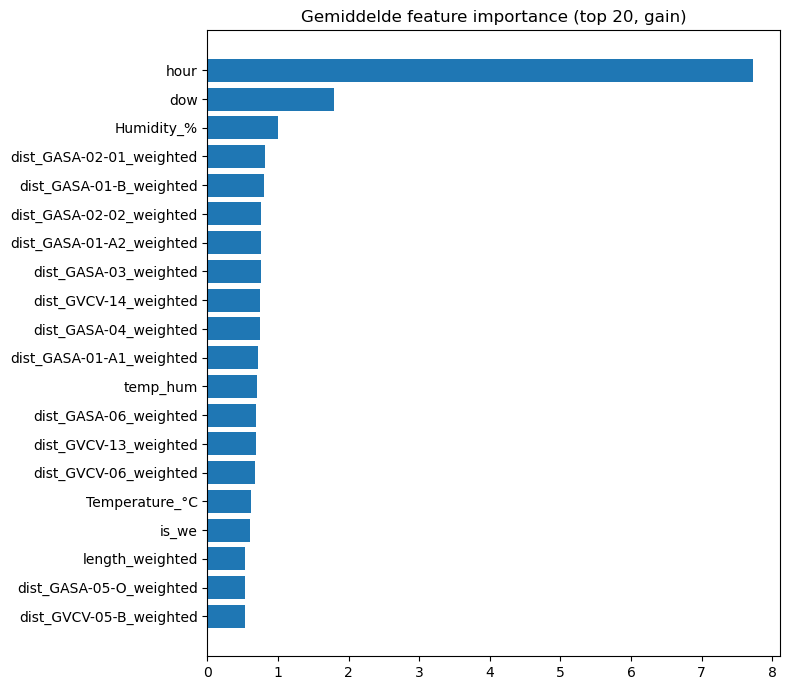

             category       gain  percentage
0    Vessel proximity  14.594982   51.399736
1                Time  10.114845   35.621859
2             Weather   2.653970    9.346594
3  Interactions/Other   1.031255    3.631811


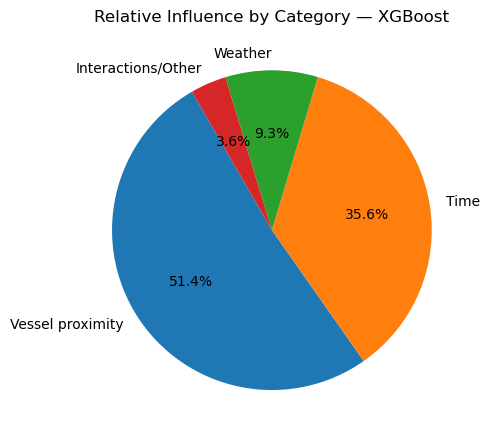

,feature,gain
0,hour,7.725126
1,dow,1.786503
2,Humidity_%,1.004138
3,dist_GASA-02-01_weighted,0.811609
4,dist_GASA-01-B_weighted,0.802098
5,dist_GASA-02-02_weighted,0.756862
6,dist_GASA-01-A2_weighted,0.756140
7,dist_GASA-03_weighted,0.751563
8,dist_GVCV-14_weighted,0.750300
9,dist_GASA-04_weighted,0.745773


In [16]:
# === Visuals & metrics voor XGBoost ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Samples
print("Sample predictions (eerste 5 rijen, eerste 5 targets):")
print(pd.DataFrame(preds[:5, :5], columns=target_cols[:5]))
print("Actuals (zelfde rijen, targets):")
print(pd.DataFrame(y_test[:5, :5], columns=target_cols[:5]))

# 2) Metrics
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, preds)
r2   = r2_score(y_test, preds)
print("XGBoost Results")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

# 3) Mean comparison
print("\n--- Mean Comparison ---")
print(f"Train target mean: {y_train.mean():.2f}")
print(f"Test  target mean: {y_test.mean():.2f}")
print(f"Pred  mean:        {preds.mean():.2f}")

# 4) Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test.ravel(), preds.ravel(), alpha=0.6)
lims = [min(y_test.min(), preds.min()), max(y_test.max(), preds.max())]
plt.plot(lims, lims, 'r--', lw=2)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual visitors"); plt.ylabel("Predicted visitors")
plt.title("XGBoost: Predicted vs Actual")
plt.grid(True); plt.tight_layout(); plt.show()

# 5) Residuals
residuals = y_test.ravel() - preds.ravel()
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=40, edgecolor='k')
plt.title("Residuals (Actual - Predicted) — XGBoost")
plt.xlabel("Error"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

# 6) Feature importance (gemiddeld over targets, 'gain')
def gain_vector(model, n_feats):
    fmap = model.get_booster().get_score(importance_type="gain")
    v = np.zeros(n_feats, dtype=float)
    for k, g in fmap.items():
        try:
            idx = int(k[1:])  # 'f12' -> 12
            if idx < n_feats: v[idx] = g
        except:
            pass
    return v

imp_mat = np.vstack([gain_vector(m, len(feature_cols)) for m in models.values()])
imp_mean = imp_mat.mean(axis=0)
top_idx = np.argsort(imp_mean)[::-1][:20]
top_feats = np.array(feature_cols)[top_idx]
plt.figure(figsize=(8,7))
plt.barh(top_feats[::-1], imp_mean[top_idx][::-1])
plt.title("Gemiddelde feature importance (top 20, gain)")
plt.tight_layout(); plt.show()

# 7) Categorieanalyse (zoals Ridge, plus tijd)
cat = []
for f in feature_cols:
    if f.startswith("dist_"): c = "Vessel proximity"
    elif f in ("Temperature_°C","Humidity_%","Rain_mm","temp_hum"): c = "Weather"
    elif f in ("hour","dow","is_we","hour_sin","hour_cos"): c = "Time"
    elif f in ("length_weighted","rain_len"): c = "Interactions/Other"
    else: c = "Other"
    cat.append(c)
cat_df = pd.DataFrame({"feature": feature_cols, "gain": imp_mean, "category": cat})
cat_sum = (cat_df.groupby("category")["gain"].sum()
           .sort_values(ascending=False).reset_index())
cat_sum["percentage"] = 100 * cat_sum["gain"] / cat_sum["gain"].sum()
print(cat_sum)

plt.figure(figsize=(5,5))
plt.pie(cat_sum["percentage"], labels=cat_sum["category"], autopct="%1.1f%%", startangle=120)
plt.title("Relative Influence by Category — XGBoost")
plt.tight_layout(); plt.show()

# 8) Top features tabel
pd.DataFrame({"feature": top_feats, "gain": imp_mean[top_idx]}).reset_index(drop=True)


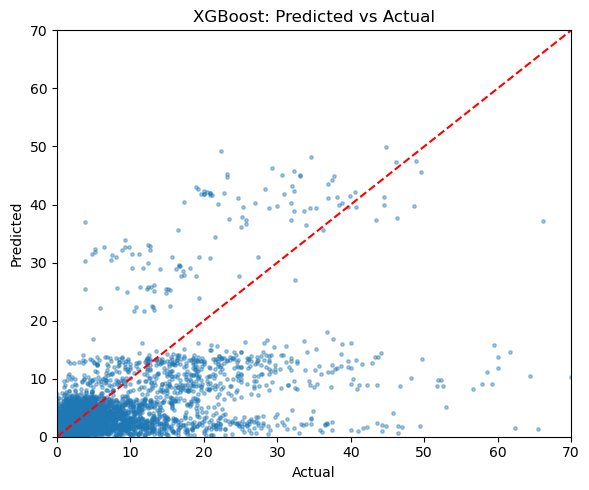

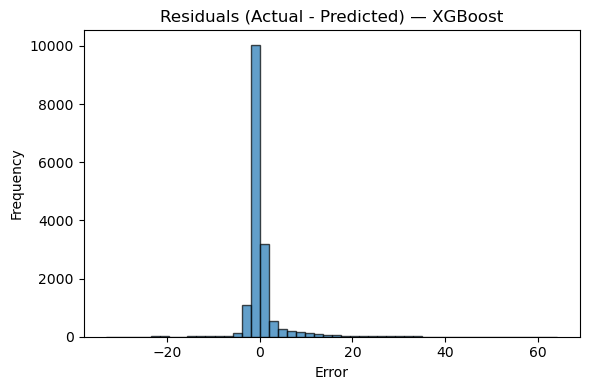

In [17]:
# === Twee figuren: Predicted vs Actual en Residuals-hist ===
import matplotlib.pyplot as plt
import numpy as np

yt = y_test.ravel()
yp = preds.ravel()

# 1) Predicted vs Actual
plt.figure(figsize=(6,5))
plt.scatter(yt, yp, s=6, alpha=0.4)
lims = [min(yt.min(), yp.min()), max(yt.max(), yp.max())]
plt.plot(lims, lims, linestyle="--", color="red")
plt.xlim(lims); plt.ylim(lims)
plt.title("XGBoost: Predicted vs Actual")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.tight_layout(); plt.show()

# 2) Residuals histogram
res = yt - yp
plt.figure(figsize=(6,4))
plt.hist(res, bins=50, alpha=0.7, edgecolor="k")
plt.title("Residuals (Actual - Predicted) — XGBoost")
plt.xlabel("Error"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()


In [18]:
# === Optioneel: testmetrics print ===
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = float(np.sqrt(mean_squared_error(y_test, preds)))
mae  = float(mean_absolute_error(y_test, preds))
print(f"Test RMSE={rmse:.4f}  MAE={mae:.4f}")


Test RMSE=4.3783  MAE=1.7864


In [ ]:
# # === 1. Data laden (zuinig) ===
# def _downcast(df):
#     for c in df.select_dtypes(include=["float64","int64"]).columns:
#         df[c] = pd.to_numeric(df[c], errors="coerce", downcast="float")
#     return df

# # vessels
# vessels = (pd.read_csv(PATH_VESSEL, low_memory=False)
#              .rename(columns={"upload-timestamp":"timestamp"})
#              .drop(columns=[c for c in ["stale_since"] if c in pd.read_csv(PATH_VESSEL, nrows=0).columns], errors="ignore"))
# vessels["timestamp"] = pd.to_datetime(vessels["timestamp"], errors="coerce")
# vessels = _downcast(vessels)

# # weather
# weather = pd.read_csv(PATH_WEATHER, low_memory=False)
# # neem eerste tijds-kolom als timestamp
# tcol = next((c for c in weather.columns if "time" in c.lower()), None)
# if tcol is None: tcol = "timestamp"
# weather = weather.rename(columns={tcol:"timestamp"})
# weather["timestamp"] = pd.to_datetime(weather["timestamp"], errors="coerce")
# weather = _downcast(weather)

# # sensors + locations
# sensors = pd.read_csv(PATH_SENSORS, parse_dates=["timestamp"], low_memory=False)
# sensors = _downcast(sensors)
# sensors_loc = pd.read_csv(PATH_SENSORS_LOC, low_memory=False).rename(columns={"Objectnummer":"sensor_id"})


In [ ]:
# # === 2. target_cols automatisch uit sensors + locations ===
# sensor_ids = set(sensors_loc["sensor_id"].astype(str))
# candidate_cols = [c for c in sensors.columns if c != "timestamp"]
# # kolommen die starten met een bekende sensor_id gevolgd door "_" en een cijferhoek
# pat = re.compile(r"^(?P<sid>.+)_(\d+)$")
# target_cols = []
# for c in candidate_cols:
#     m = pat.match(c)
#     if m and m.group("sid") in sensor_ids:
#         target_cols.append(c)
# target_cols = sorted(target_cols)
# if not target_cols:
#     raise RuntimeError("Geen target-kolommen gevonden in sensors. Controleer kolomnamen.")

# print(f"{len(target_cols)} targets gevonden.")


72 targets gevonden.


In [ ]:
# # === 3. Feature-tabel bouwen (join op timestamp) ===
# # 0) timestamps uniform (UTC-naive). Sla over als je dit al eerder deed.
# for _df in (sensors, weather, vessels):
#     _df["timestamp"] = pd.to_datetime(_df["timestamp"], utc=True, errors="coerce").dt.tz_localize(None)

# # 1) numerieke kolommen die aanwezig zijn
# def numeric_non_ts(df):
#     return [c for c in df.columns
#             if c != "timestamp" and pd.api.types.is_numeric_dtype(df[c])]

# w_cols_all = numeric_non_ts(weather)
# v_cols_all = numeric_non_ts(vessels)
# w_cols = pd.Index(["timestamp"] + w_cols_all).intersection(weather.columns).tolist()
# v_cols = pd.Index(["timestamp"] + v_cols_all).intersection(vessels.columns).tolist()

# # 2) join met suffixes om naamclashes te voorkomen
# left = sensors[["timestamp"] + target_cols]
# mid  = weather[w_cols]
# right= vessels[v_cols]

# agg_df = (left.merge(mid, on="timestamp", how="inner", suffixes=("", "_w"))
#                .merge(right, on="timestamp", how="inner", suffixes=("", "_v")))

# # 3) schoonmaak
# agg_df = agg_df.sort_values("timestamp").dropna().reset_index(drop=True)

# # 4) features bepalen (alles behalve targets en timestamp)
# exclude = set(target_cols) | {"timestamp"}
# feature_cols = [c for c in agg_df.columns if c not in exclude]
# feature_names = feature_cols

# # 5) sanity checks
# assert len(agg_df) > 0, "agg_df is leeg na merges."
# assert len(feature_cols) > 0, "Geen feature-kolommen gevonden."

# print(f"agg_df: {agg_df.shape[0]} rijen, {len(feature_cols)} features, {len(target_cols)} targets")


AssertionError: agg_df is leeg na merges.

In [ ]:
# # === 4. Tijd-split bepalen en train/test maken ===
# # 80/20 tijdsplit
# ts_split = agg_df["timestamp"].quantile(0.8)
# split_time = pd.to_datetime(ts_split)

# train_mask = agg_df["timestamp"] < split_time
# test_mask  = ~train_mask

# X_train = agg_df.loc[train_mask, feature_cols].astype("float32").values
# y_train = agg_df.loc[train_mask, target_cols].astype("float32").values
# X_test  = agg_df.loc[test_mask,  feature_cols].astype("float32").values
# y_test  = agg_df.loc[test_mask,  target_cols].astype("float32").values

# print(f"split_time={split_time} | train={train_mask.sum()} test={test_mask.sum()}")


In [ ]:
# # === 5. Train per target met early stopping en logging ===
# models, logs = {}, {}
# X_tr, X_va, y_tr_all, y_va_all = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# for i, t in enumerate(target_cols):
#     print(f"\n== {t} ==")
#     y_tr, y_va = y_tr_all[:, i], y_va_all[:, i]
#     model = XGBRegressor(**xgb_params)
#     model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=VERBOSE_EVERY)
#     models[t] = model
#     logs[t] = model.evals_result()


[0]	validation_0-rmse:1.38707	validation_1-rmse:1.51582
[25]	validation_0-rmse:0.57122	validation_1-rmse:0.88185
[50]	validation_0-rmse:0.30675	validation_1-rmse:0.71470
[75]	validation_0-rmse:0.20796	validation_1-rmse:0.66089
[100]	validation_0-rmse:0.14990	validation_1-rmse:0.63647
[125]	validation_0-rmse:0.11582	validation_1-rmse:0.61965
[150]	validation_0-rmse:0.09060	validation_1-rmse:0.60667
[175]	validation_0-rmse:0.07443	validation_1-rmse:0.60068
[200]	validation_0-rmse:0.05948	validation_1-rmse:0.59976
[225]	validation_0-rmse:0.04903	validation_1-rmse:0.59799
[250]	validation_0-rmse:0.04074	validation_1-rmse:0.59727
[275]	validation_0-rmse:0.03344	validation_1-rmse:0.59728
[300]	validation_0-rmse:0.02747	validation_1-rmse:0.59714
[325]	validation_0-rmse:0.02370	validation_1-rmse:0.59705
[350]	validation_0-rmse:0.02001	validation_1-rmse:0.59625
[375]	validation_0-rmse:0.01705	validation_1-rmse:0.59658
[400]	validation_0-rmse:0.01467	validation_1-rmse:0.59682
[425]	validation_0-

In [ ]:
# # === 6. Testevaluatie en export met timestamp ===
# preds = np.column_stack([models[t].predict(X_test) for t in target_cols]).astype("float32")
# rmse = float(np.sqrt(((y_test - preds) ** 2).mean()))
# mae  = float(np.abs(y_test - preds).mean())
# print(f"Test RMSE={rmse:.4f}  MAE={mae:.4f}")

# ts_test = agg_df.loc[test_mask, "timestamp"].reset_index(drop=True)
# pred_df = pd.DataFrame(preds, columns=target_cols)
# pred_df.insert(0, "timestamp", pd.to_datetime(ts_test))
# pred_df.to_csv("predicted_sensor_values_3min_xgb.csv", index=False)


In [ ]:
# # === 7. Figuren zoals bij Ridge (voor XGBoost) ===
# yt = agg_df.loc[test_mask, target_cols].values.ravel()
# yp = preds.ravel()

# plt.figure(figsize=(6,5))
# plt.scatter(yt, yp, s=6, alpha=0.4)
# lims = [min(yt.min(), yp.min()), max(yt.max(), yp.max())]
# plt.plot(lims, lims, linestyle="--", color="red")
# plt.xlim(lims); plt.ylim(lims)
# plt.title("XGBoost: Predicted vs Actual")
# plt.xlabel("Actual visitors"); plt.ylabel("Predicted visitors")
# plt.tight_layout(); plt.show()

# res = yt - yp
# plt.figure(figsize=(6,4))
# plt.hist(res, bins=50, alpha=0.7, edgecolor="k")
# plt.title("Residuals Distribution (Actual - Predicted) — XGBoost")
# plt.xlabel("Error"); plt.ylabel("Frequency")
# plt.tight_layout(); plt.show()



===== Target: CMSA-GAKH-01_0 =====
[0]	validation_0-rmse:1.55583	validation_1-rmse:1.49032
[25]	validation_0-rmse:0.70376	validation_1-rmse:0.70265
[50]	validation_0-rmse:0.48138	validation_1-rmse:0.54759
[75]	validation_0-rmse:0.40601	validation_1-rmse:0.52218
[100]	validation_0-rmse:0.35749	validation_1-rmse:0.51765
[125]	validation_0-rmse:0.32381	validation_1-rmse:0.52003
[150]	validation_0-rmse:0.29528	validation_1-rmse:0.52001
[175]	validation_0-rmse:0.27288	validation_1-rmse:0.52118
[200]	validation_0-rmse:0.25038	validation_1-rmse:0.52217
Best iteration: 102  |  valid RMSE: 0.5175

===== Target: CMSA-GAKH-01_180 =====
[0]	validation_0-rmse:1.29620	validation_1-rmse:1.26300
[25]	validation_0-rmse:0.59331	validation_1-rmse:0.61640
[50]	validation_0-rmse:0.41563	validation_1-rmse:0.49736
[75]	validation_0-rmse:0.34927	validation_1-rmse:0.48217
[100]	validation_0-rmse:0.30578	validation_1-rmse:0.47865
[125]	validation_0-rmse:0.27899	validation_1-rmse:0.47510
[150]	validation_0-rmse

In [33]:
# # ===== 06. Testevaluatie en export =====
# preds = np.column_stack([models[t].predict(X_test) for t in target_cols]).astype("float32")
# rmse = float(np.sqrt(((y_test - preds) ** 2).mean()))
# mae  = float(np.abs(y_test - preds).mean())
# print(f"Test RMSE: {rmse:.4f}   Test MAE: {mae:.4f}")

# pred_df = pd.DataFrame(preds, columns=target_cols)
# pred_df.to_csv("predicted_sensor_values_3min_xgb.csv", index=False)
# pred_df.head()


Test RMSE: 2.1446   Test MAE: 1.2298


,CMSA-GAKH-01_0,CMSA-GAKH-01_180,CMSA-GAWW-11_120,CMSA-GAWW-11_300,CMSA-GAWW-12_115,CMSA-GAWW-12_295,CMSA-GAWW-13_120,CMSA-GAWW-13_300,CMSA-GAWW-14_40,CMSA-GAWW-14_220,...,GVCV-08_45,GVCV-08_225,GVCV-09_80,GVCV-09_260,GVCV-11_50,GVCV-11_230,GVCV-13_10,GVCV-13_190,GVCV-14_90,GVCV-14_270
0,0.099985,0.050207,2.171055,1.971670,3.058259,4.811533,4.012941,6.443559,0.810320,0.811179,...,0.149264,0.216249,0.001903,0.002425,1.764784,1.592454,3.634071,1.397848,1.756366,1.153779
1,0.134242,0.057336,2.904022,2.553181,2.751112,5.421911,6.501954,5.509185,0.866070,1.386883,...,0.149264,0.216249,0.001903,0.002425,3.142668,1.606813,3.754227,1.810733,1.756366,2.100223
2,0.123642,0.070125,2.325491,2.228803,4.070583,5.347284,4.713557,4.487014,0.887495,1.315091,...,0.149264,0.216249,0.001903,0.002425,1.759546,1.606813,3.485663,1.662289,2.046439,2.145724
3,0.124594,0.076901,1.288074,1.291930,3.407107,4.320276,2.847969,3.445984,0.787187,0.767611,...,0.154050,0.216249,0.001903,0.002425,1.764784,1.592454,3.396531,1.874983,2.046439,1.302518
4,0.216008,0.064819,2.386175,2.217898,3.373978,4.722909,4.363056,4.270514,0.736209,1.175873,...,0.149264,0.216249,0.001903,0.002425,1.759546,1.606813,3.485663,1.377480,2.122157,2.145724


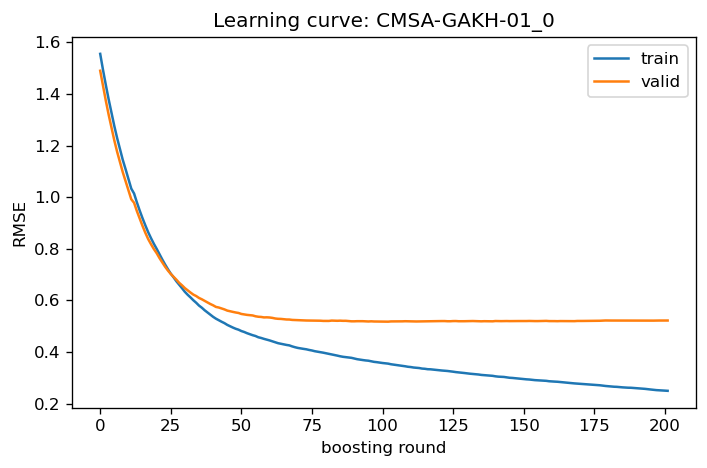

In [34]:
# # ===== 07. Learning curves plotten =====
# def plot_learning_curve(target):
#     ev = logs[target]
#     train_rmse = ev["validation_0"]["rmse"]
#     valid_rmse = ev["validation_1"]["rmse"]
#     plt.figure(figsize=(6,4))
#     plt.plot(train_rmse, label="train")
#     plt.plot(valid_rmse, label="valid")
#     plt.xlabel("boosting round")
#     plt.ylabel("RMSE")
#     plt.title(f"Learning curve: {target}")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # voorbeeld
# plot_learning_curve(target_cols[0])


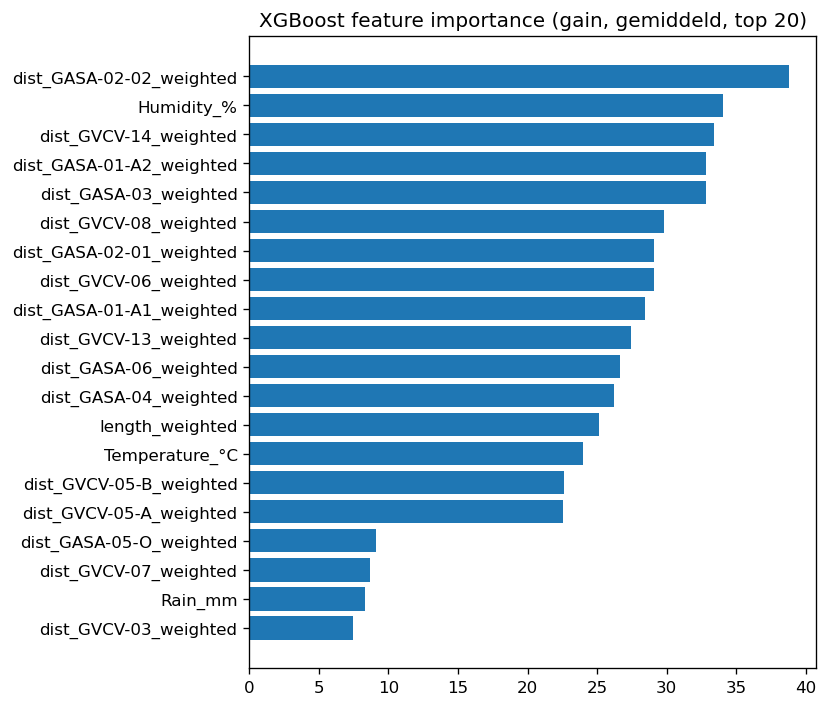

In [35]:
# # ===== 08. Feature importance (gemiddeld) =====
# def mean_gain_importance(models_dict, feature_names):
#     gains = []
#     for t, m in models_dict.items():
#         booster = m.get_booster()
#         fmap = booster.get_score(importance_type="gain")  # {'f0': gain, ...}
#         vec = np.zeros(len(feature_names), dtype="float64")
#         for k, v in fmap.items():
#             idx = int(k[1:])
#             if idx < len(vec):
#                 vec[idx] = v
#         gains.append(vec)
#     return np.mean(np.vstack(gains), axis=0)

# imp = mean_gain_importance(models, feature_names)
# order = np.argsort(imp)[::-1][:20]
# plt.figure(figsize=(7,6))
# plt.barh(np.array(feature_names)[order][::-1], imp[order][::-1])
# plt.title("XGBoost feature importance (gain, gemiddeld, top 20)")
# plt.tight_layout()
# plt.show()


In [36]:
# # === Features/targets afleiden (werkt zowel als je al X_train hebt, als alleen agg_df) ===
# # Vereist: ofwel X_train/y_train/X_test/y_test bestaan al,
# # of je hebt één DataFrame 'agg_df' + lijst 'target_cols' (zoals in je Ridge-notebook).

# if "X_train" not in globals():
#     assert "agg_df" in globals() and "target_cols" in globals(), "Zorg dat agg_df en target_cols bestaan"
#     feature_cols = [c for c in agg_df.columns if c not in target_cols and c not in ("timestamp",)]
#     X = agg_df[feature_cols].values
#     y = agg_df[target_cols].values
#     # zelfde split als eerder:
#     assert "split_time" in globals(), "Definieer split_time zoals in Ridge-notebook"
#     train_mask = agg_df["timestamp"] < split_time
#     test_mask  = ~train_mask
#     X_train, X_test = X[train_mask.values], X[test_mask.values]
#     y_train, y_test = y[train_mask.values], y[test_mask.values]
#     test_index = agg_df.loc[test_mask, "timestamp"].reset_index(drop=True)
#     feature_names = feature_cols
# else:
#     # Als je al gesplitst hebt, zorg voor feature_names en test_index
#     if "feature_names" not in globals():
#         feature_names = getattr(X_train, "columns", None)
#         feature_names = list(feature_names) if feature_names is not None else [f"f{i}" for i in range(X_train.shape[1])]
#     if "test_index" not in globals():
#         # fallback voor tijdstempels
#         test_index = pd.Series(range(len(X_test)), name="timestamp")


In [39]:
# # ===== 09. Opslaan modellen (optioneel) =====
# import joblib, os
# os.makedirs("xgb_models", exist_ok=True)
# for t, m in models.items():
#     joblib.dump(m, f"xgb_models/model_{t}.joblib")
# print("Modellen opgeslagen in xgb_models/")


Modellen opgeslagen in xgb_models/


In [40]:
# # ===== 10. Snelle sanity check =====
# print("Sample predictions:", preds[:3])
# print("Actuals:", y_test[:3])


Sample predictions: [[ 9.9984698e-02  5.0207447e-02  2.1710548e+00  1.9716702e+00
   3.0582595e+00  4.8115330e+00  4.0129414e+00  6.4435587e+00
   8.1032020e-01  8.1117946e-01  2.0470088e+00  3.5870535e+00
   5.6072431e+00  1.8778876e+00  5.3521293e-01  3.6492613e-01
   3.5638454e+00  3.8939354e+00  3.0417266e-01  4.1682523e-01
   3.8927931e-01  3.0007899e-01  2.0244892e-01  3.2232451e-01
   5.8114946e-01  5.5285394e-01  2.9080302e-02  8.2632720e-02
   3.3385339e-01  2.2011952e-01  8.0094852e-02  1.9965769e-01
   6.7840725e-01  1.2658441e-01  9.6797422e-03  1.2521691e+00
   1.4465919e-01  3.0417353e-01  2.9036570e-01  3.0839029e-01
   1.1442422e-01  4.7525269e-01  2.9768065e-01  3.0192998e-01
   1.6181698e-01  3.8563529e-01  0.0000000e+00  0.0000000e+00
   1.6117259e+00  1.3671073e+00  8.6459583e-01  4.6793133e-01
   1.9313936e+00  1.3562483e+00  1.9433529e+00  1.2300133e+00
   1.3877673e+00  3.7086684e-01  1.0144156e+00  1.4438560e+00
   6.0259753e-01  7.8436649e-01  5.3363204e-01  3.